# Customer Segmentation (Clustering)

## Project Overview

This project focuses on **Unsupervised Learning** to identify distinct groups of mall customers based on their purchasing behavior and demographics. Unlike previous projects (Regression/Classification), there is no target variable; the goal is to uncover hidden patterns and structures within the data using **Clustering** techniques.

## Business Objective

By clustering customers, we aim to empower the marketing team to perform **Targeted Marketing**. Understanding customer segments (e.g., "High Spenders" vs. "Budget Conscious") allows for:
* Personalized marketing strategies.
* Optimized resource allocation.
* Improved customer retention.

## Dataset Description

The analysis uses the standard **Mall Customers Dataset**, which includes the following features:
* **CustomerID:** Unique ID assigned to the customer.
* **Genre:** Gender of the customer.
* **Age:** Age of the customer.
* **Annual Income (k$):** Annual Income of the customer.
* **Spending Score (1-100):** Score assigned by the mall based on customer behavior and spending nature.

## Key Methodologies

1.  **Exploratory Data Analysis (EDA):** Visualizing distributions and correlations to understand feature relationships.
2.  **Data Preprocessing & Finding Optimal Clusters:** Feature Scaling (`StandardScaler`) to normalize income and spending scores and determining the optimal number of clusters ($K$) using the **Elbow Method** and **Silhouette Score**.
3.  **2D Model Training & Cluster Visualization:** Implementing **K-Means Clustering** and visualizing clusters through a scatterplot.
4.  **Cluster Profiling & Business Insights:** Interpreting the resulting groups to derive actionable business insights.
5.  **Advanced: 3D Clustering & Dimensionality Reduction (PCA)** Using `PCA (Principal Component Analysis)` to visualize high-dimensional clusters in 2D space.

In [2]:
# Install Libraries

%pip install pandas numpy matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.8 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [seaborn]m6/7 [seaborn]ib]
Note: you may need to restart the kernel to use updated packages.


# 1. Exploratory Data Analysis (EDA)

Before applying any clustering algorithms, we must understand the underlying structure of the data. Since we do not have a target variable, our focus is on **distribution patterns** and **potential natural groupings**.

### Objectives for this Section:
1.  **Univariate Analysis:** Analyze the distribution of individual features (`Age`, `Annual Income`, `Spending Score`) using histograms and KDE plots to detect skewness or outliers.
2.  **Bivariate Analysis:** Explore relationships between feature pairs. Specifically, the **Annual Income vs. Spending Score** scatter plot is critical for visually identifying potential clusters.
3.  **Multivariate Analysis:** Use Pairplots and Correlation Heatmaps to understand the overall interaction between all numerical variables and Gender.

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Settings
# Set visualization style
sns.set(style="whitegrid")
# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Load Dataset (Mall_Customers must be in the same directory)
try:
    df = pd.read_csv('Mall_Customers.csv')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ Error: 'Mall_Customers.csv' not found. Please check the file path.")


Matplotlib is building the font cache; this may take a moment.


✅ Dataset loaded successfully!


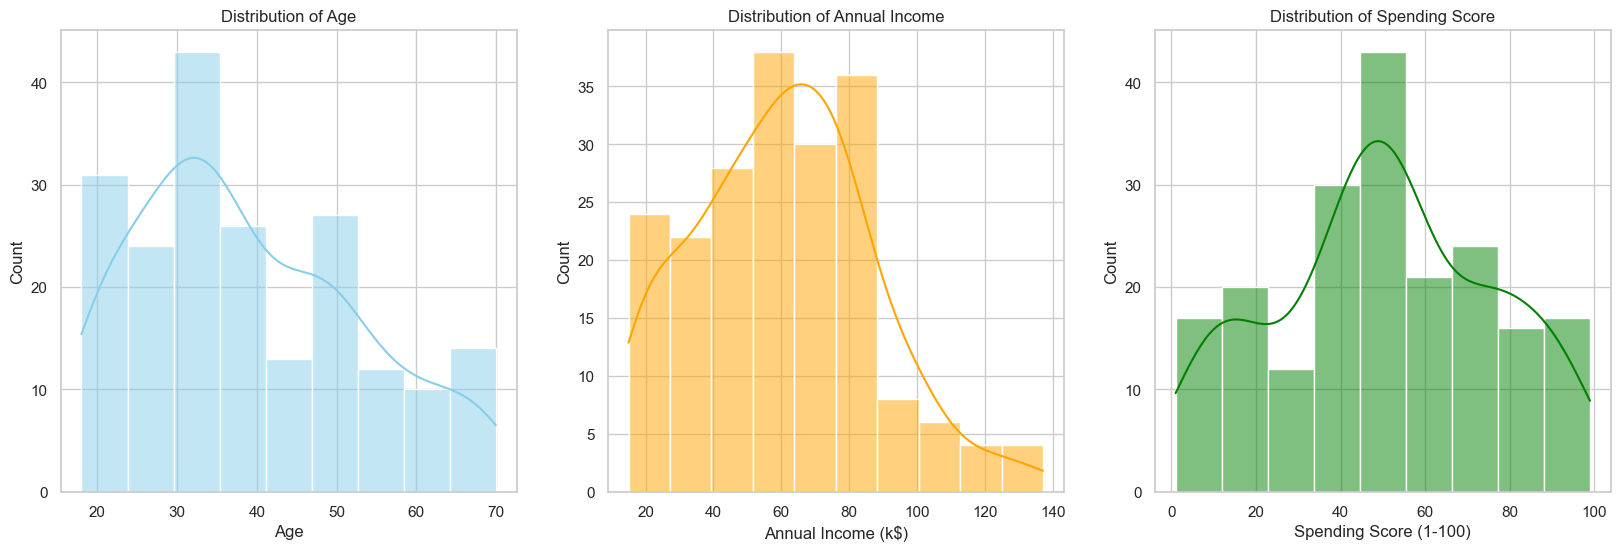

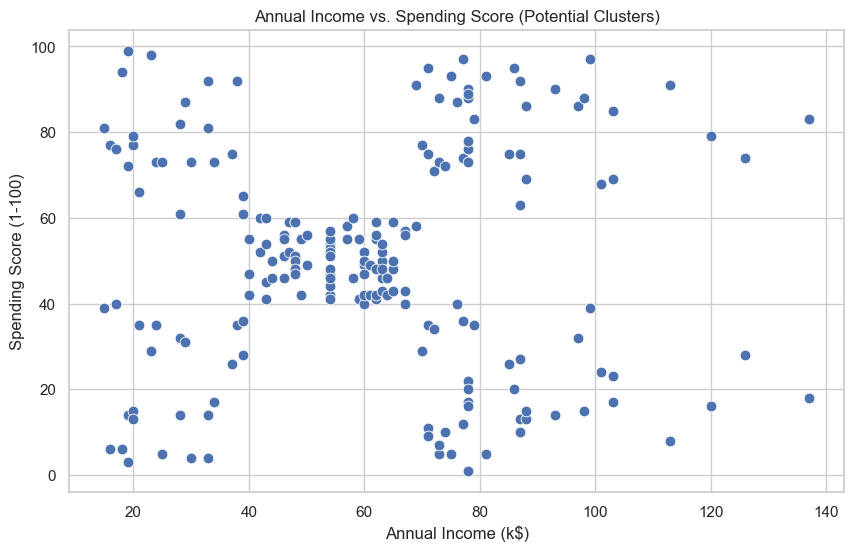

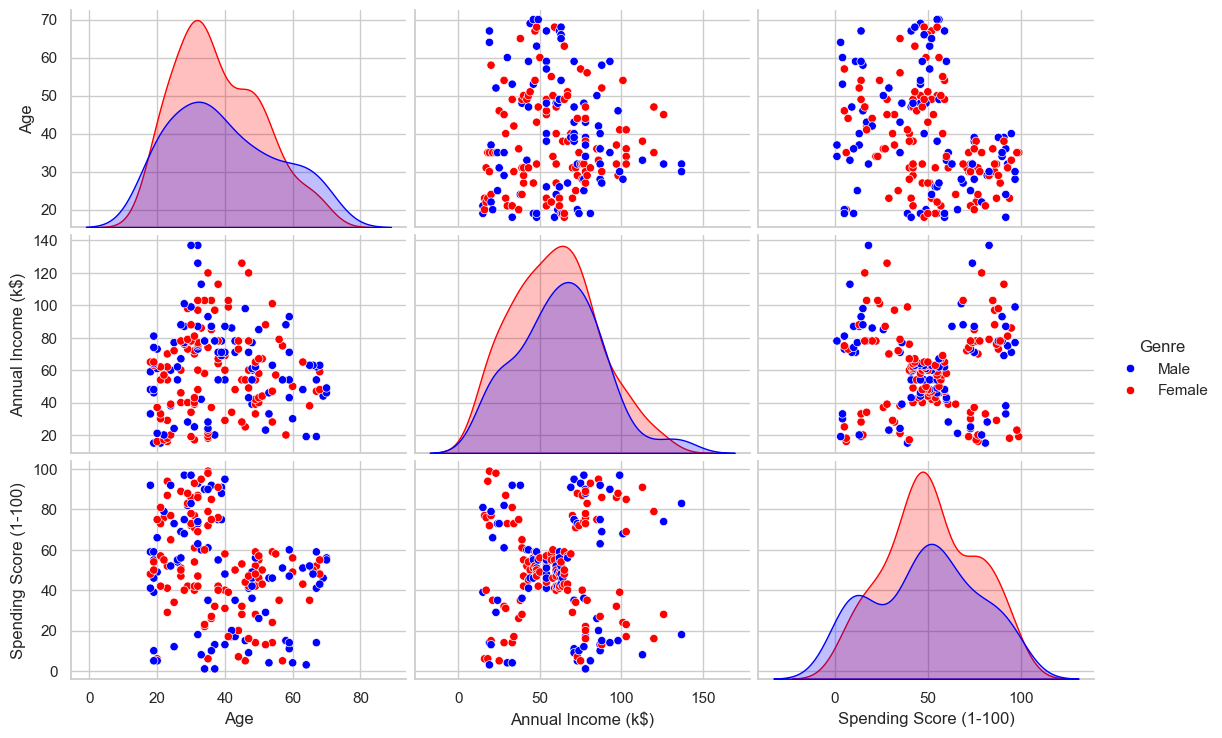

In [34]:
# Analysis

# Univariate Analysis (Distributions)

plt.figure(figsize=(20, 6))

# Plot 1: Age Distribution

plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, color='skyblue')
plt.title('Distribution of Age')

# Plot 2: Annual Income Distribution

plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], kde=True, color='orange')
plt.title('Distribution of Annual Income')

# Plot 3: Spending Score Distribution

plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], kde=True, color='green')
plt.title('Distribution of Spending Score')

plt.show()

# Bivariate Analysis (The "Money Plot")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, s=60)
plt.title('Annual Income vs. Spending Score (Potential Clusters)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

# Multivariate Analysis (Pairplot)

df_viz = df.copy()

df_viz['Genre'] = df_viz['Genre'].map({0: 'Female', 1: 'Male'})

vars_to_plot = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

my_palette = {'Female': 'red', 'Male': 'blue'}

sns.pairplot(df_viz, vars=vars_to_plot, hue='Genre', aspect=1.5, palette=my_palette)
plt.show()

In [31]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster,Cluster Label,Cluster_3D,Gender Label
0,1,1,19,15,39,4,Budget Watchers,1,Male
1,2,1,21,15,81,2,Careless Spenders,1,Male
2,3,0,20,16,6,4,Budget Watchers,0,Female
3,4,0,23,16,77,2,Careless Spenders,1,Female
4,5,0,31,17,40,4,Budget Watchers,1,Female


In [ ]:
plt.title('Annual Income vs. Spending Score (Potential Clusters)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

# Multivariate Analysis (Pairplot)

sns.pairplot(df.drop('CustomerID', axis=1), hue='Genre', aspect=1.5)
plt.show()

# 2. Data Preprocessing & Finding Optimal Clusters

We start from a 2 dimensions clustering: Annual Income (k$) & Spending Score (1-100)

Before training the K-Means model, we must transform the raw data and scientifically determine the optimal number of segments ($K$).

### Data Preparation Steps:

1.  **Label Encoding:** The categorical `Genre` variable is converted into numeric format (`Male`=1, `Female`=0) to be interpretable by the algorithm.

2.  **Feature Scaling:** Since K-Means relies on **Euclidean distance**, features with large magnitudes (like `Annual Income`) can disproportionately influence the results compared to smaller scales (like `Spending Score` or `Age`). We apply **StandardScaler** to normalize all features ($mean=0, std=1$), ensuring equal weighting.

### Cluster Optimization (Choosing K):

To avoid guessing the number of customer groups, we employ two validation techniques:

* **The Elbow Method:** We calculate the **WCSS** (Within-Cluster Sum of Squares) for different values of $K$. We look for the "elbow point" where the decrease in inertia slows down significantly, indicating the optimal trade-off between compactness and complexity.

* **Silhouette Score:** As a validation metric, we calculate the Silhouette Coefficient (range -1 to +1). A score closer to **+1** indicates that data points are well-matched to their own cluster and poorly matched to neighboring clusters, confirming good separation.

In [24]:
# Encoding Genre

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Genre'] = le.fit_transform(df['Genre'])

print("\Info & First DF Rows")
df.info()
df.head()

\Info & First DF Rows
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    int64 
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
 5   Cluster                 200 non-null    int32 
 6   Cluster Label           200 non-null    object
 7   Cluster_3D              200 non-null    int32 
 8   Gender Label            200 non-null    object
dtypes: int32(2), int64(5), object(2)
memory usage: 12.6+ KB


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster,Cluster Label,Cluster_3D,Gender Label
0,1,1,19,15,39,4,Budget Watchers,1,Male
1,2,1,21,15,81,2,Careless Spenders,1,Male
2,3,0,20,16,6,4,Budget Watchers,0,Female
3,4,0,23,16,77,2,Careless Spenders,1,Female
4,5,0,31,17,40,4,Budget Watchers,1,Female


In [ ]:
# Feature Selection & Scaling (Annual Income (k$) & Spending Score (1-100))

from sklearn.preprocessing import StandardScaler

features_to_cluster = ['Annual Income (k$)', 'Spending Score (1-100)']
X_raw = df[features_to_cluster].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Check
print("✅ Preprocessing Completed.")
print("\nFirst 5 rows of Raw Data:")
print(X_raw[:5])
print("\nFirst 5 rows of Scaled Data (Inputs for K-Means):")
print(X_scaled[:5])

✅ Preprocessing Completed.

First 5 rows of Raw Data:
[[15 39]
 [15 81]
 [16  6]
 [16 77]
 [17 40]]

First 5 rows of Scaled Data (Inputs for K-Means):
[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]


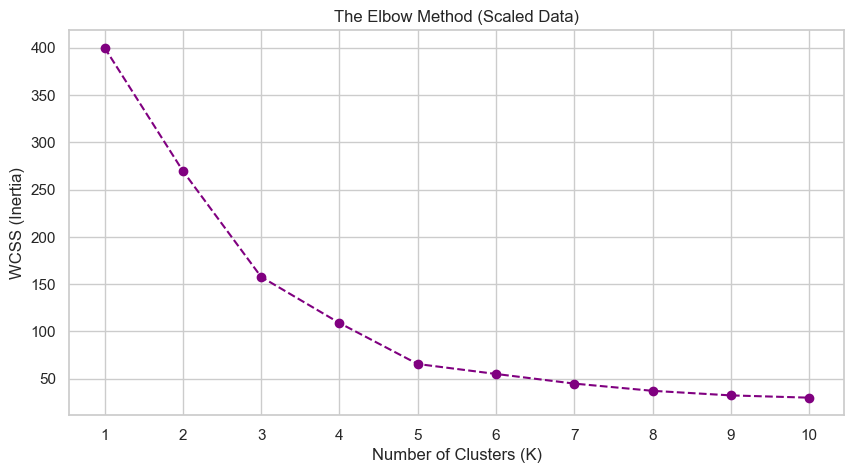

In [27]:
# Elbow Method

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = [] 

# Loop for testing 1-10 Clusters
for i in range(1, 11):
   
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='purple')
plt.title('The Elbow Method (Scaled Data)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

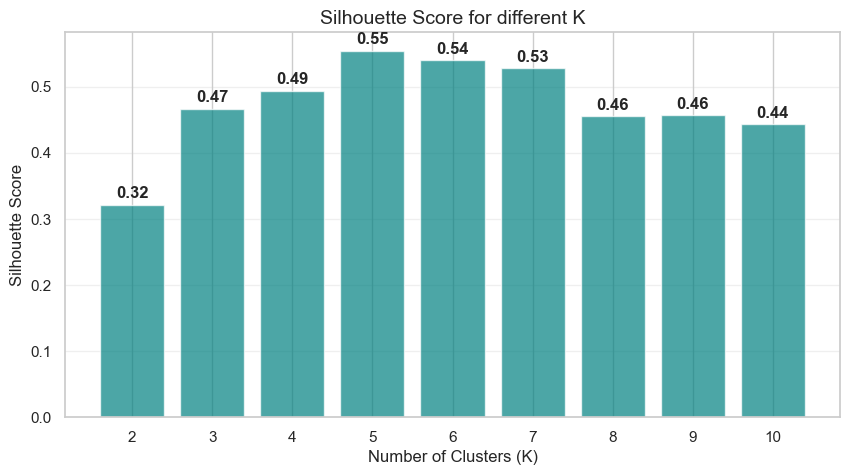

🏆 The K with the highest Silhouette Score is: 5


In [28]:
# Silhouette Score

from sklearn.metrics import silhouette_score

silhouette_scores = []

# Testing from K=2 to K=10 

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Visualization

plt.figure(figsize=(10, 5))
plt.bar(range(2, 11), silhouette_scores, color='teal', alpha=0.7)
plt.title('Silhouette Score for different K', fontsize=14)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))


for i, score in enumerate(silhouette_scores):
    plt.text(i + 2, score + 0.01, f"{score:.2f}", ha='center', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

# Check

best_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]
print(f"🏆 The K with the highest Silhouette Score is: {best_k}")

# 3. 2D Model Training & Cluster Visualization

We apply the **K-Means algorithm** with the optimal number of clusters ($K=5$).
After training, we visualize the clusters on a 2D Scatter Plot to verify the segmentation.

### 📊 Visualization Logic:
* **X-Axis:** Annual Income (k$)
* **Y-Axis:** Spending Score (1-100)
* **Color:** Determined by the assigned Cluster (0 to 4)
* **Centroids:** The mathematical center of each cluster (marked as 'X').

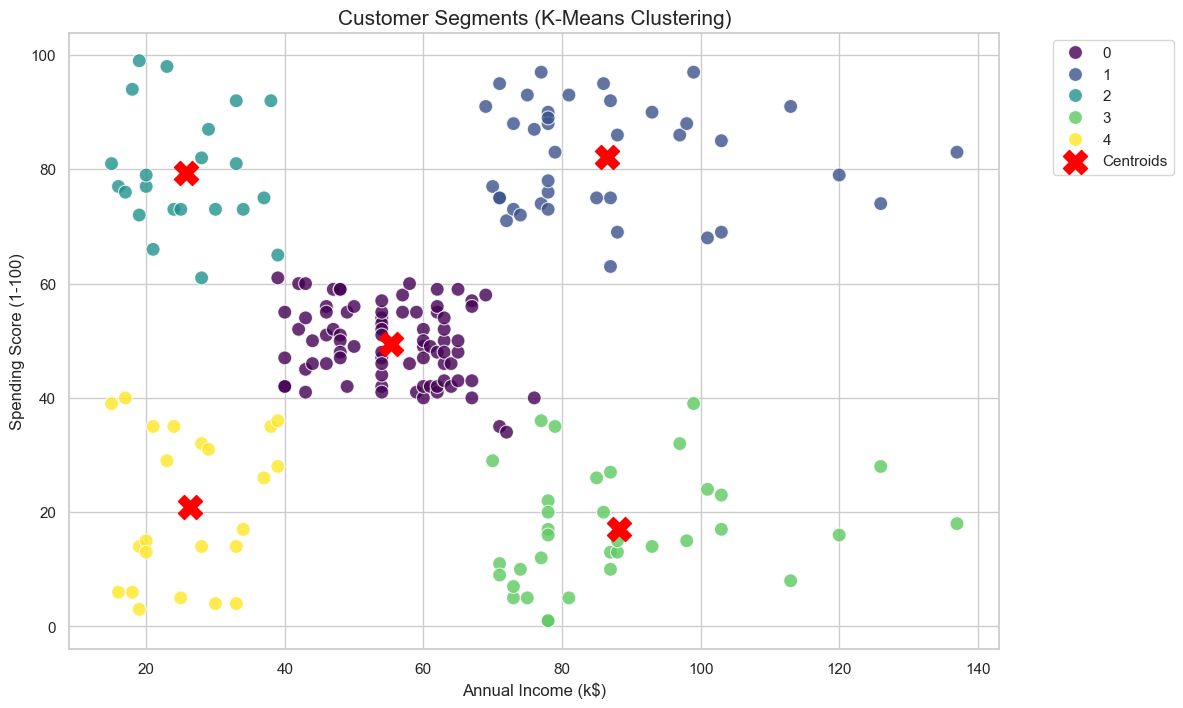

Cluster Centers (Original Scale):


,Annual Income (k$),Spending Score (1-100)
Cluster,,
0,55.296296,49.518519
1,86.538462,82.128205
2,25.727273,79.363636
3,88.200000,17.114286
4,26.304348,20.913043


In [14]:
# Model Training (K=5) and Visualization 

kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


plt.figure(figsize=(12, 8))

# Scatter Plot 

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', 
                data=df, hue='Cluster', palette='viridis', s=100, alpha=0.8)

# Centroids definition and plot

centroids = df.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()

plt.scatter(centroids['Annual Income (k$)'], centroids['Spending Score (1-100)'], 
            s=300, c='red', marker='X', label='Centroids')

plt.title('Customer Segments (K-Means Clustering)', fontsize=15)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Check

print("Cluster Centers (Original Scale):")
display(centroids)

# 4. Cluster Profiling & Business Insights

Now that we have established 5 distinct clusters, we need to interpret them to provide actionable insights for the marketing team.

### 📝 Profiling Strategy:
We will calculate the **mean values** of `Age`, `Annual Income`, and `Spending Score` for each cluster to identify their unique characteristics.

| Cluster ID | Label | Profile Description |
| :---: | :--- | :--- |
| **0** | **Balanced Buyers** | Average income and average spending. The "standard" customer. |
| **1** | **Golden Geese** | High income and high spending. The most valuable segment (VIPs). |
| **2** | **Careless Spenders** | Low income but high spending. Potential impulse buyers. |
| **3** | **Cautious Wealth** | High income but low spending. Potential for upsell if value is demonstrated. |
| **4** | **Budget Watchers** | Low income and low spending. Price-sensitive customers. |


In [15]:
# Cluster Profiling

cluster_summary = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

# Add "Counts" Column

cluster_summary['Count'] = df['Cluster'].value_counts()

# Add Percentage

cluster_summary['Percentage (%)'] = (cluster_summary['Count'] / len(df)) * 100

# Round

cluster_summary = cluster_summary.round(2)

print("📊 Detailed Cluster Profiles:")
display(cluster_summary)

📊 Detailed Cluster Profiles:


,Age,Annual Income (k$),Spending Score (1-100),Count,Percentage (%)
Cluster,,,,,
0,42.72,55.30,49.52,81,40.5
1,32.69,86.54,82.13,39,19.5
2,25.27,25.73,79.36,22,11.0
3,41.11,88.20,17.11,35,17.5
4,45.22,26.30,20.91,23,11.5


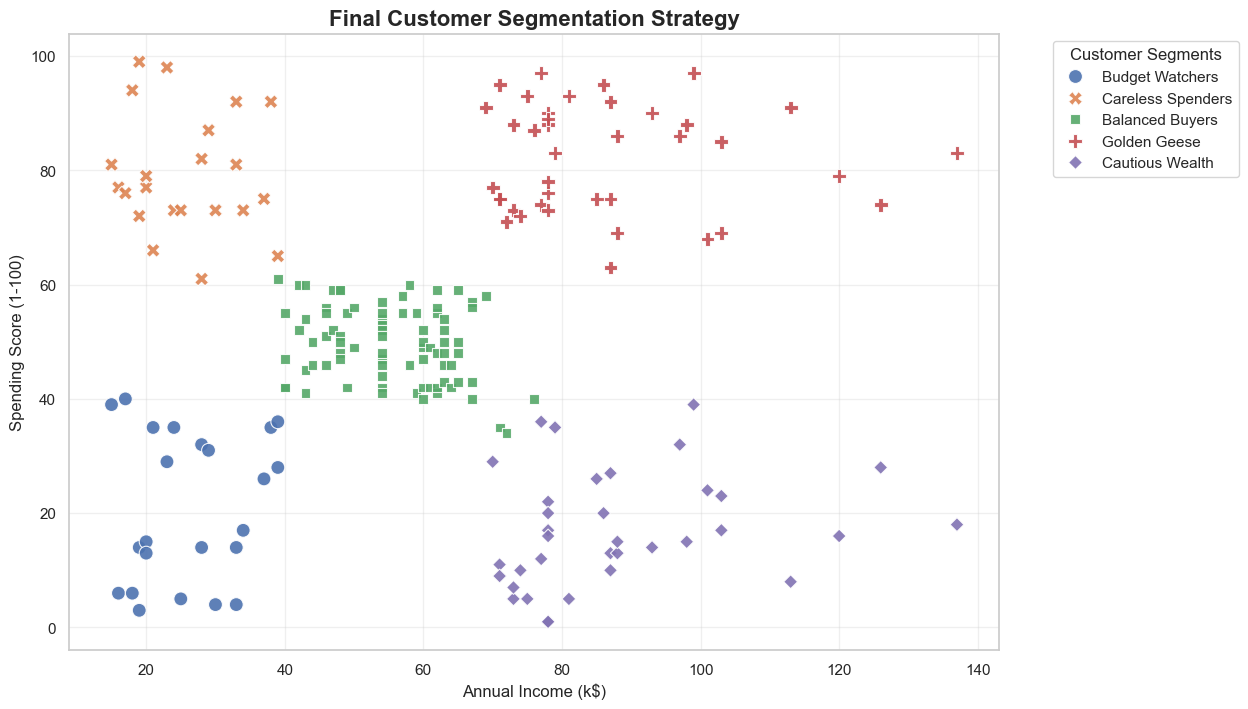

📢 MARKETING STRATEGY RECOMMENDATIONS:
--------------------------------------------------
👉 GOLDEN GEESE: Target with exclusive offers, loyalty programs, and new product alerts. Keep them happy!
👉 CARELESS SPENDERS: Target with discount sales and 'limited time' offers to trigger impulse buys.
👉 BALANCED BUYERS: Use standard promotions. Try to upsell them to become 'Golden Geese'.
👉 CAUTIOUS WEALTH: Focus on 'Quality' and 'Value' marketing. They have money but need a reason to spend.
👉 BUDGET WATCHERS: Don't spend too much ad budget here. Send them clearance sale notifications.


In [16]:
# Marketing Analysis

# Mapping Labels Dictionary
cluster_names = {
    0: "Balanced Buyers",
    1: "Golden Geese",
    2: "Careless Spenders",
    3: "Cautious Wealth",
    4: "Budget Watchers"
}

df['Cluster Label'] = df['Cluster'].map(cluster_names)

# Final Visualization
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', 
                data=df, hue='Cluster Label', style='Cluster Label', 
                s=100, palette='deep', alpha=0.9)

plt.title('Final Customer Segmentation Strategy', fontsize=16, fontweight='bold')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Customer Segments")
plt.grid(True, alpha=0.3)
plt.show()

# Marketing Recommendations

print("📢 MARKETING STRATEGY RECOMMENDATIONS:")
print("-" * 50)

strategies = {
    "Golden Geese": "Target with exclusive offers, loyalty programs, and new product alerts. Keep them happy!",
    "Careless Spenders": "Target with discount sales and 'limited time' offers to trigger impulse buys.",
    "Balanced Buyers": "Use standard promotions. Try to upsell them to become 'Golden Geese'.",
    "Cautious Wealth": "Focus on 'Quality' and 'Value' marketing. They have money but need a reason to spend.",
    "Budget Watchers": "Don't spend too much ad budget here. Send them clearance sale notifications."
}

for segment, strategy in strategies.items():
    print(f"👉 {segment.upper()}: {strategy}")

# 5. Advanced: 3D Clustering & Dimensionality Reduction (PCA)

To increase the model's complexity and realism, we now include **Age** as a third feature.
Since visualizing 3D data (Age, Income, Spending) is difficult on a standard plot, we employ **PCA (Principal Component Analysis)**.

### Concept:

PCA reduces the dimensionality of the data while retaining most of the variance (information). It transforms our 3 features into 2 "Principal Components" to allow for clear 2D visualization.

### Steps:

* **3D Clustering**

1.  Select 3 Features: `Age`, `Annual Income`, `Spending Score`.
2.  Scale the data (StandardScaler).
3.  Re-train K-Means (Assuming K=5 for consistency).
4.  Apply PCA to reduce to 2 components.
5.  Visualize the result.

* **Loading Analysis**

* **PCA Interpretation: Decoding the Dimensions**

* **3D Visualization**

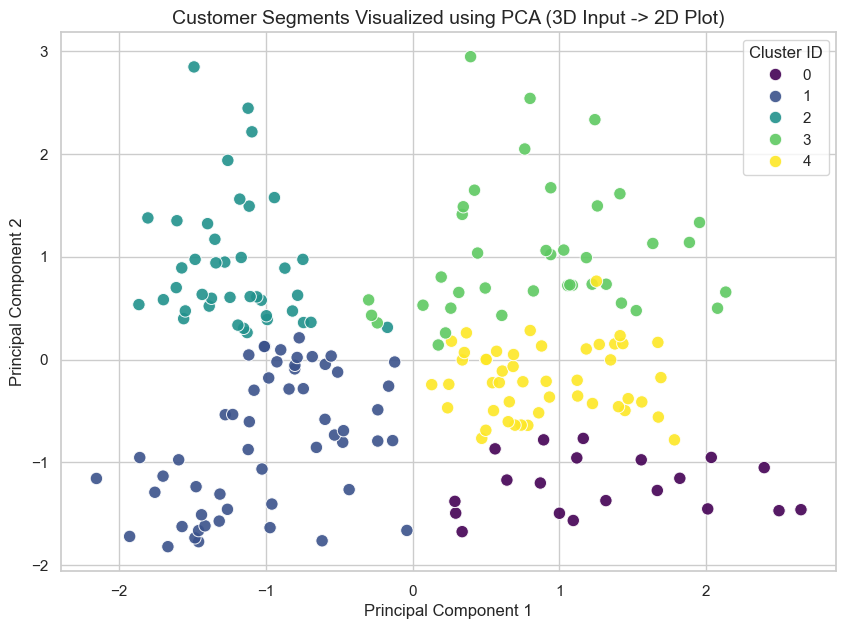

Explained Variance Ratio: [0.44266167 0.33308378]
Total Information Retained: 77.57%


In [18]:
# 3D Clustering

from sklearn.decomposition import PCA

# Prepare 3D Data (Add Age)

features_3d = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X_3d = df[features_3d].values

# Scaling 

scaler_3d = StandardScaler()
X_3d_scaled = scaler_3d.fit_transform(X_3d)

# Train K-Means (on 3 features and 5 clusters)

kmeans_3d = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
clusters_3d = kmeans_3d.fit_predict(X_3d_scaled)

df['Cluster_3D'] = clusters_3d

# Apply PCA (Principal Component Analysis for Dimensionality Reduction)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_3d_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster_3D'] = clusters_3d

# Visualize PCA Results

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_3D', data=pca_df, 
                palette='viridis', s=80, alpha=0.9)

plt.title('Customer Segments Visualized using PCA (3D Input -> 2D Plot)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

# Explain Variance

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Information Retained: {sum(pca.explained_variance_ratio_) * 100:.2f}%")

Virtual components meaning:


,PC1,PC2
Age,0.706382,0.030141
Annual Income (k$),-0.048024,0.998832
Spending Score (1-100),-0.706199,-0.037775


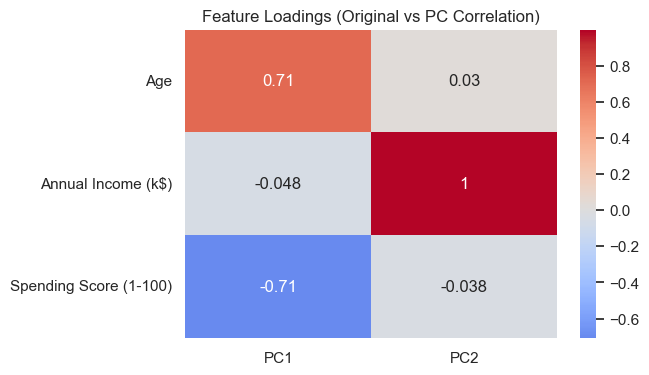

In [19]:
# Loadings Analysis

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features_3d)

print("Virtual components meaning:")
display(loadings)

# Heatmap Visualization

plt.figure(figsize=(6, 4))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Loadings (Original vs PC Correlation)')
plt.show()

## PCA Interpretation: Decoding the Dimensions

By analyzing the **Feature Loadings** heatmap, we have successfully decoded the abstract Principal Components into actionable business dimensions. The PCA transformation revealed specific underlying patterns in customer behavior:

### **1. PC2 (Y-Axis) $\rightarrow$ The "Wealth" Axis**

* **Dominant Feature:** `Annual Income` (Correlation: ~1.0).
* **Interpretation:** This axis is a pure reflection of financial status.
    * **High Y-Value:** High Income.
    * **Low Y-Value:** Low Income.

### **2. PC1 (X-Axis) $\rightarrow$ The "Generational Conservatism" Axis**

* **Dominant Features:** `Age` (+0.71) and `Spending Score` (-0.71).
* **Interpretation:** This axis captures an inverse relationship between Age and Spending.
* **High X-Value (Right):** Older customers with lower spending scores (**Conservative/Prudent**).
* **Low X-Value (Left):** Younger customers with higher spending scores (**Impulsive/Trend-focused**).

### **Strategic Mapping**

This interpretation allows us to read the 2D PCA plot as a strategic map:
*   **Top-Left Quadrant:** Young, Wealthy, High Spenders (**The "Golden Geese"**).
*   **Top-Right Quadrant:** Older, Wealthy, Low Spenders (**"Cautious Wealth"**).
*   **Bottom-Left Quadrant:** Young, Low Income, High Spenders (**"Careless Spenders"**).
*   **Bottom-Right Quadrant** Older, Low Income, Low Spenders (**"Budget Watchers"**).


### **Interactive 3D Visualization**

This visualization serves to check the real clusters and confirm wheter the PCA assumptions were right


In [23]:
# 3D Visualization

import plotly.express as px

# Create Readable Labels for Genre

gender_map = {0: 'Female', 1: 'Male'}
df['Gender Label'] = df['Genre'].map(gender_map)

#Interactive 3D Plot

fig = px.scatter_3d(
    df, 
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    z='Age',
    color='Cluster Label',     
    symbol='Gender Label',      
    opacity=0.8,
    title='<b>Interactive 3D Segmentation (with Gender)</b>',
    hover_data=['CustomerID']
)

# Styling

fig.update_traces(marker=dict(size=5))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis_title='Income (k$)',
        yaxis_title='Spending Score',
        zaxis_title='Age'
    ),
    legend_title="Legend"
)

fig.show()

# 🛍️ Project A3: Customer Segmentation (Unsupervised Learning)

![Python](https://img.shields.io/badge/Python-3.8%2B-blue)
![Library](https://img.shields.io/badge/Library-Scikit--Learn-orange)
![Visualization](https://img.shields.io/badge/Visualization-Plotly%20%7C%20Seaborn-purple)

## 📖 Project Overview

This project focuses on **Unsupervised Machine Learning** to identify distinct customer segments within a mall's dataset. Unlike supervised learning, we discover hidden patterns and structures in the data to understand **who** the customers are without predefined labels.

The analysis moves from basic exploratory analysis to advanced **K-Means Clustering**, validated by **Silhouette Scores**, and visualized using **PCA (Principal Component Analysis)** and **Interactive 3D Plots**.

---

## 🎯 Business Objective

The goal is to empower the marketing team to optimize resource allocation by targeting specific customer groups:
* **High-Value Customers (VIPs):** For loyalty programs.
* **Budget-Conscious Shoppers:** For discount campaigns.
* **Inactive/Low-Spenders:** For re-engagement strategies.

---

## 📸 Visualizations & Analysis

### 1. Exploratory Data Analysis (EDA)

Understanding the data distribution and relationships before modeling.

**A. Univariate Analysis (Distributions)**

![EDA Distributions](./Customer_Segmentation_Images/EDA_Univariate_Density.png)
*Distribution of Age, Annual Income, and Spending Score.*

**B. Bivariate Analysis (Income vs. Spending)**

![EDA Scatter](./Customer_Segmentation_Images/EDA_Scatterplot.png)
*The critical "Money Plot" showing potential natural clusters.*

**C. Multivariate Analysis (Pairplot)**

![EDA Pairplot](./Customer_Segmentation_Images/EDA_Pairplot.png)
*Pairwise relationships colored by Gender to inspect overlaps.*

---

### 2. Defining the Optimal K (Cluster Selection)

We used two mathematical methods to validate that **K=5** is the optimal number of segments.

| Method 1: The Elbow Method | Method 2: Silhouette Score |
| :---: | :---: |
| ![Elbow Method](./Customer_Segmentation_Images/2D_Elbow_Method.png) | ![Silhouette Score](./Customer_Segmentation_Images/2D_Silhouette_Score.png) |
| *The "Elbow" appears clearly at K=5.* | *Highest separation score achieved at K=5.* |

---

### 3. 2D Customer Segmentation (Final Model)

![Final 2D Clusters](./Customer_Segmentation_Images/2D_K-Means_Clustering_Scatterplot.png)
*Final visualization of the 5 customer segments based on Income and Spending Score.*

---

### 4. PCA Customer Segmentation (Dimensionality Reduction)

Since we included **Age** in the final model (3 variables), we used PCA to project the data into 2D space.
![PCA Clusters](./Customer_Segmentation_Images/PCA_Clusters.png)
*Data projected onto Principal Components. Note how the "Age" factor changes the cluster shapes compared to the simple 2D plot.*

---

### 5. Loadings Analysis (Interpretation)

To understand what the PCA axes actually mean, we analyzed the feature loadings.
![Feature Loadings](./Customer_Segmentation_Images/Feature_Loadings.png)
* **PC1 (X-Axis):** Represents "Generational Conservatism" (Older people spend less, Younger people spend more).
* **PC2 (Y-Axis):** Represents pure "Wealth" (Annual Income).

---

## 📊 Key Results: Customer Personas
Based on the analysis, we identified 5 distinct profiles:

| Cluster Label | Persona Name | Characteristics | Strategy |
| :---: | :--- | :--- | :--- |
| **0** | **Balanced Buyers** | Average Income, Average Spending. | Standard promotions & Nudging. |
| **1** | **Golden Geese** | High Income, High Spending. | **VIP Treatment**, Exclusive offers. |
| **2** | **Careless Spenders** | Low Income, High Spending (Young). | Impulse buy offers, Flash sales. |
| **3** | **Cautious Wealth** | High Income, Low Spending (Older). | Focus on Quality & Value proposition. |
| **4** | **Budget Watchers** | Low Income, Low Spending. | Clearance sales, low-cost recommendations. |

---

## ⚙️ How to Run
1.  Clone the repository.
2.  Install dependencies:
    ```bash
    pip install pandas numpy matplotlib seaborn scikit-learn plotly nbformat
    ```
3.  Run the Jupyter Notebook `A3_Customer_Segmentation.ipynb`.